In [121]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical


In [122]:
# Load the data into a pandas DataFrame
print(os.getcwd())
df = pd.read_csv(
    filepath_or_buffer=os.getcwd()+'/../../data/monks/monks-3.train',
    names=['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'],
    delimiter=' '
)

# Display the loaded data
df

/Users/gianlucapanzani/Documents/GitHub/Machine_Learning_Project/frameworks/tfkeras


,target,col1,col2,col3,col4,col5,col6,id
NaN,1,1,1,1,1,1,2,data_2
NaN,1,1,1,1,1,2,1,data_3
NaN,1,1,1,1,1,2,2,data_4
NaN,0,1,1,1,1,3,1,data_5
NaN,0,1,1,1,1,4,1,data_7
...,...,...,...,...,...,...,...,...
NaN,0,3,3,2,2,2,2,data_420
NaN,0,3,3,2,2,3,2,data_422
NaN,0,3,3,2,3,1,1,data_425
NaN,0,3,3,2,3,3,2,data_430


In [123]:
# Initializing labels/targets vector
y = df['target'].values.astype(float)

# Drop of the IDs and the targets
df = df.drop(columns=['target','id'], axis=1)

# Initializing the one-hot DataFrame
df_copy = df.copy(deep=True)

# Iteration on the columns of the DataFrame
for column in df.columns:

    # Creation of the one-hot encoding's columns
    df_one_hot = pd.get_dummies(df[column], dtype=float)

    # Change the name of the columns
    df_one_hot = df_one_hot.set_axis([column+'_'+str(col) for col in df_one_hot.columns], axis=1)

    # Drop of the initial column
    df_copy.drop(labels=column, axis=1, inplace=True)

    # Concatenation of the new columns to the DataFrame
    df_copy = pd.concat([df_copy,df_one_hot], axis=1)

# Print of the obtained DataFrame   col1_2	col1_3	 col2_2	col2_3  col3_2	col3_3  col4_2	col4_3	col5_2	col5_3 col6_2		
df_copy

,col1_1,col1_2,col1_3,col2_1,col2_2,col2_3,col3_1,col3_2,col4_1,col4_2,col4_3,col5_1,col5_2,col5_3,col5_4,col6_1,col6_2
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Grid Search

In [124]:
# Parameters' space for Grid Search
param_space = {
    'input_units': [17],
    'units': [3, 4],
    'optimizer': ['sgd'],
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'batch_size': [15, 30, 60, 120],
    'epochs': [390],
    'weight_decay': [0.001, 0.01, 0.02],
    'momentum': [0.4, 0.5, 0.6, 0.7],
    'activation': ['tanh', 'relu'],
    'output_activation': ['sigmoid'],
    'metrics': ['accuracy']
}

# Model Selection

## K-fold Cross Validation 

In [125]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping

# Assigning new DataFrame to Data set variable
X = df_copy.values

# Number of trials with random combinations
num_trials = 25

# K-fold Cross-validation
k = 5
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store training and validation accuracies
trials_training_accuracies = []
trials_validation_accuracies = []

# Lists to store best hyperparameters
best_hyperparameters = {
    'trial': 0,
    'params': {},
    'mean_training_accuracy': 0, 
    'mean_validation_accuracy': 0
}

# For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
for i in range(num_trials):
    
    # Random parameters
    params = {
        'input_units': np.random.choice(param_space['input_units']),
        'units': np.random.choice(param_space['units']),
        'optimizer': np.random.choice(param_space['optimizer']),
        'learning_rate': np.random.choice(param_space['learning_rate']),
        'batch_size': np.random.choice(param_space['batch_size']),
        'epochs': np.random.choice(param_space['epochs']),
        'weight_decay': np.random.choice(param_space['weight_decay']),
        'momentum': np.random.choice(param_space['momentum']),
        'activation': np.random.choice(param_space['activation']),
        'output_activation': np.random.choice(param_space['output_activation']),
        'metrics': np.random.choice(param_space['metrics']),
    }

    # Lists to store fold-wise accuracies
    fold_training_accuracies = []
    fold_validation_accuracies = []

    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Build the model
        model = Sequential()
        model.add(Dense(units=params['input_units'], activation=params['activation'], use_bias=True))
        model.add(Dense(units=params['units'], activation=params['activation'], use_bias=True))
        model.add(Dense(units=1, activation=params['output_activation'], use_bias=True))

        # Set the optimizer with the sampled learning rate
        opt = optimizers.legacy.SGD(learning_rate=params['learning_rate'], momentum=params['momentum'])

        # Sets the Loss Function, the Optimizer used in the model, and the Metrics used for evaluation
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[params['metrics']])

        # Set the Early Stopping for the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Training of the model with validation split and early stopping
        history = model.fit(
            x=X_train,
            y=y_train,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],  # Add early stopping callback
            verbose=0
        )

        # Evaluate on both training and validation sets
        training_loss, training_accuracy     = model.evaluate(X_train, y_train, verbose=0)
        validation_loss, validation_accuracy = model.evaluate(X_val, y_val, verbose=0)

        # Add the TR accuracy and VL accuracy to the lists (to compute the mean)
        fold_training_accuracies.append(training_accuracy)
        fold_validation_accuracies.append(validation_accuracy)

    # Calculate the Mean of the Accuracies (for this trial)
    mean_training_accuracy_i = np.mean(fold_training_accuracies)
    mean_validation_accuracy_i = np.mean(fold_validation_accuracies)

    # Store the Mean of the Accuracies for each Trail
    trials_training_accuracies.append(mean_training_accuracy_i)
    trials_validation_accuracies.append(mean_validation_accuracy_i)

    # Print mean accuracies and hyperparameters for this trial
    print(f"Trial {i+1}: Mean Training Accuracy={mean_training_accuracy_i:.4f}, Mean Validation Accuracy={mean_validation_accuracy_i:.4f}")
    print("Hyperparameters:", params)

    # Update best hyperparameters if current trial has higher validation accuracy
    if mean_validation_accuracy_i > best_hyperparameters['mean_validation_accuracy']:
        best_hyperparameters['trial'] = i + 1
        best_hyperparameters['params'] = params
        best_hyperparameters['mean_training_accuracy'] = mean_training_accuracy_i
        best_hyperparameters['mean_validation_accuracy'] = mean_validation_accuracy_i
    
    # Case of best Hyperparameters already found
    if best_hyperparameters['mean_validation_accuracy'] == 1:
        break

# Print best hyperparameters
print("\nBest Hyperparameters:")
print("Trial:", best_hyperparameters['trial'])
print("Hyperparameters:", best_hyperparameters['params'])
print("Mean Training Accuracy:", best_hyperparameters['mean_training_accuracy'])
print("Mean Validation Accuracy:", best_hyperparameters['mean_validation_accuracy'])


Trial 1: Mean Training Accuracy=0.9673, Mean Validation Accuracy=0.9343
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.1, 'batch_size': 120, 'epochs': 390, 'weight_decay': 0.02, 'momentum': 0.7, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
Trial 2: Mean Training Accuracy=0.9447, Mean Validation Accuracy=0.9263
Hyperparameters: {'input_units': 17, 'units': 4, 'optimizer': 'sgd', 'learning_rate': 0.4, 'batch_size': 60, 'epochs': 390, 'weight_decay': 0.001, 'momentum': 0.4, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
Trial 3: Mean Training Accuracy=0.9591, Mean Validation Accuracy=0.9260
Hyperparameters: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.3, 'batch_size': 15, 'epochs': 390, 'weight_decay': 0.001, 'momentum': 0.5, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
Trial 4: Mean Training Accuracy=0.9652, Mean Validation Accur

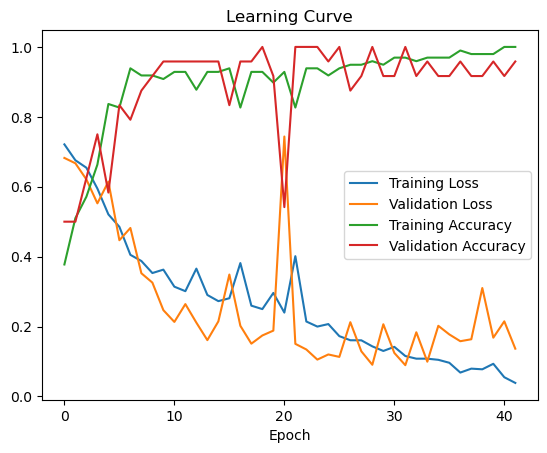

In [126]:
# Plot the learning curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.legend()


In [127]:
# Print the best Hyperparameters selected
print(f"Hyperparameters selected: {best_hyperparameters['params']}")

# Best parameters
params = {
    'input_units': best_hyperparameters['params']['input_units'],
    'units': best_hyperparameters['params']['units'],
    'optimizer': best_hyperparameters['params']['optimizer'],
    'learning_rate': best_hyperparameters['params']['learning_rate'],
    'batch_size': best_hyperparameters['params']['batch_size'],
    'epochs': best_hyperparameters['params']['epochs'],
    'weight_decay': best_hyperparameters['params']['weight_decay'],
    'momentum': best_hyperparameters['params']['momentum'],
    'activation': best_hyperparameters['params']['activation'],
    'metrics': best_hyperparameters['params']['metrics']
}

# Build the model
model = Sequential()
model.add(Dense(units=params['input_units'], activation=params['activation'], use_bias=True))
model.add(Dense(units=params['units'], activation=params['activation'], use_bias=True))
model.add(Dense(units=1, activation='sigmoid', use_bias=True))

# Set the optimizer with the sampled learning rate
opt = optimizers.legacy.SGD(learning_rate=params['learning_rate'], momentum=params['momentum'])

# Sets the Loss Function, the Optimizer used in the model, and the Metrics used for evaluation
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[params['metrics']])

# Set the Early Stopping for the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

'''
# Lists to store fold-wise accuracies
fold_training_accuracies = []
fold_validation_accuracies = []

# For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
for train_index, val_index in kfold.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Training of the model with validation split and early stopping
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],  # Add early stopping callback
        verbose=0
    )

    # Evaluate on both training and validation sets
    training_loss, training_accuracy     = model.evaluate(X_train, y_train, verbose=0)
    validation_loss, validation_accuracy = model.evaluate(X_val, y_val, verbose=0)

    # Add the TR accuracy and VL accuracy to the lists (to compute the mean)
    fold_training_accuracies.append(training_accuracy)
    fold_validation_accuracies.append(validation_accuracy)

# Calculate the Mean of the Accuracies (for this trial)
mean_training_accuracy_i = np.mean(fold_training_accuracies)
mean_validation_accuracy_i = np.mean(fold_validation_accuracies)

# Print mean accuracies and hyperparameters for this trial
print(f"Mean Training Accuracy={mean_training_accuracy_i:.4f}, Mean Validation Accuracy={mean_validation_accuracy_i:.4f}")
'''


Hyperparameters selected: {'input_units': 17, 'units': 3, 'optimizer': 'sgd', 'learning_rate': 0.4, 'batch_size': 15, 'epochs': 390, 'weight_decay': 0.001, 'momentum': 0.6, 'activation': 'relu', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}


'\n# Lists to store fold-wise accuracies\nfold_training_accuracies = []\nfold_validation_accuracies = []\n\n# For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>\nfor train_index, val_index in kfold.split(X, y):\n    X_train, X_val = X[train_index], X[val_index]\n    y_train, y_val = y[train_index], y[val_index]\n\n    # Training of the model with validation split and early stopping\n    history = model.fit(\n        x=X_train,\n        y=y_train,\n        epochs=params[\'epochs\'],\n        batch_size=params[\'batch_size\'],\n        validation_data=(X_val, y_val),\n        callbacks=[early_stopping],  # Add early stopping callback\n        verbose=0\n    )\n\n    # Evaluate on both training and validation sets\n    training_loss, training_accuracy     = model.evaluate(X_train, y_train, verbose=0)\n    validation_loss, validation_accuracy = model.evaluate(X_val, y_val, verbose=0)\n\n    # Add the TR accuracy and VL accuracy to the lists (to

# Test Phase

In [128]:
# Load the Test set into a pandas DataFrame
print(os.getcwd())
df_test = pd.read_csv(
    filepath_or_buffer=os.getcwd()+'/../../data/monks/monks-3.test',
    names=['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'],
    delimiter=' '
)

# Display the loaded data
df_test.head

/Users/gianlucapanzani/Documents/GitHub/Machine_Learning_Project/frameworks/tfkeras


<bound method NDFrame.head of      target  col1  col2  col3  col4  col5  col6        id
NaN       1     1     1     1     1     1     1    data_1
NaN       1     1     1     1     1     1     2    data_2
NaN       1     1     1     1     1     2     1    data_3
NaN       1     1     1     1     1     2     2    data_4
NaN       1     1     1     1     1     3     1    data_5
..      ...   ...   ...   ...   ...   ...   ...       ...
NaN       0     3     3     2     3     2     2  data_428
NaN       0     3     3     2     3     3     1  data_429
NaN       0     3     3     2     3     3     2  data_430
NaN       0     3     3     2     3     4     1  data_431
NaN       0     3     3     2     3     4     2  data_432

[432 rows x 8 columns]>

In [129]:
# Initializing labels/targets vector
y_test = df_test['target'].values.astype(float)

# Drop of the IDs and the targets
df_test = df_test.drop(columns=['target','id'], axis=1)

# Initializing the one-hot DataFrame
df_copy_test = df_test.copy(deep=True)

# Iteration on the columns of the DataFrame
for column in df_test.columns:

    # Creation of the one-hot encoding's columns
    df_one_hot = pd.get_dummies(df_test[column], dtype=float)

    # Change the name of the columns
    df_one_hot = df_one_hot.set_axis([column+'_'+str(col) for col in df_one_hot.columns], axis=1)

    # Drop of the initial column
    df_copy_test.drop(labels=column, axis=1, inplace=True)

    # Concatenation of the new columns to the DataFrame
    df_copy_test = pd.concat([df_copy_test,df_one_hot], axis=1)

# Print of the obtained DataFrame
df_copy_test

,col1_1,col1_2,col1_3,col2_1,col2_2,col2_3,col3_1,col3_2,col4_1,col4_2,col4_3,col5_1,col5_2,col5_3,col5_4,col6_1,col6_2
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


## Test of the Model

In [131]:
# Assigning new DataFrame to Data set variable
X_test = df_copy_test

# Training of the model with validation split and early stopping
history = model.fit(
    x=X_test,
    y=y_test,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # Add early stopping callback
    verbose=1
)

# Evaluate on both training and validation sets
testing_loss, testing_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print mean accuracies and hyperparameters for this trial
print(f"Test Accuracy={testing_accuracy:.4f}")



Epoch 1/390
29/29 [==============================] - 0s 2ms/step - loss: 4.1328e-06 - accuracy: 1.0000 - val_loss: 6.7884e-06 - val_accuracy: 1.0000
Epoch 2/390
29/29 [==============================] - 0s 701us/step - loss: 4.1208e-06 - accuracy: 1.0000 - val_loss: 6.7687e-06 - val_accuracy: 1.0000
Epoch 3/390
29/29 [==============================] - 0s 717us/step - loss: 4.1083e-06 - accuracy: 1.0000 - val_loss: 6.7492e-06 - val_accuracy: 1.0000
Epoch 4/390
29/29 [==============================] - 0s 651us/step - loss: 4.0956e-06 - accuracy: 1.0000 - val_loss: 6.7288e-06 - val_accuracy: 1.0000
Epoch 5/390
29/29 [==============================] - 0s 667us/step - loss: 4.0837e-06 - accuracy: 1.0000 - val_loss: 6.7085e-06 - val_accuracy: 1.0000
Epoch 6/390
29/29 [==============================] - 0s 647us/step - loss: 4.0727e-06 - accuracy: 1.0000 - val_loss: 6.6897e-06 - val_accuracy: 1.0000
Epoch 7/390
29/29 [==============================] - 0s 693us/step - loss: 4.0605e-06 - accuracy